# Classifying Images of Digits

1. Have a visual inspection into the optical digit data from UCI. Use as many classification models as you have available in your own library to apply the training data on them.
2. Evaluate the models with respect to precision, recall and f1-score and print a confusion table.
3. For the decision tree, interchange the possible impurity functions and see which of the decision tree models works best.

## Load Data

In [3]:
# shell scripts for downloading the data and placing it in a corresponding directory
!mkdir optdigits 
!curl -o optdigits/data.train "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tra"
!curl -o optdigits/data.test "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tes"
!curl -o optdigits/description "http://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.names"
# download the description and display it here.
!cat optdigits/description

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  3  550k    3 20108    0     0  20108      0  0:00:28 --:--:--  0:00:28 22980
100  550k  100  550k    0     0   550k      0  0:00:01  0:00:01 --:--:--  342k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 84  258k   84  217k    0     0   217k      0  0:00:01  0:00:01 --:--:--  196k
100  258k  100  258k    0     0   258k      0  0:00:01  0:00:01 --:--:--  232k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's have a look into the downloaded data file for training.

In [6]:
!head -n 5 optdigits/data.train

'head' is not recognized as an internal or external command,
operable program or batch file.


Apparently, it's a comma-separated file with 64 pixel intensity values and one class value.

In [2]:
df_train = pd.read_csv("./optdigits/data.train", header=None)
df_test = pd.read_csv("./optdigits/data.test", header=None)

We can put the data into memory and bring it in a numpy-format so that we can feed it into our models.

In [3]:
X_training, y_training = df_train.loc[:,0:63], df_train.loc[:,64]
X_testing, y_testing = df_test.loc[:,0:63], df_test.loc[:,64]
X_train = X_training.to_numpy().reshape(-1, 8, 8)
X_test = X_testing.to_numpy().reshape(-1, 8, 8)
y_train = y_training.to_numpy()
y_test = y_testing.to_numpy()

In [39]:
y_train

array([0, 0, 7, ..., 6, 6, 7], dtype=int64)

A single data element looks like:

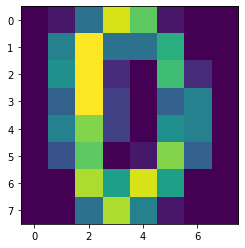

In [5]:
plt.imshow(X_train[0])

# Change log fro binary to multiclass classification for Logistic regression
as we are having not binary classification but multiclass we must:
1. implement Cross entropy loss function
2. change activation function from sigmoig to softmax
3. change weights initialization approach 
4. additionaly to compute loss we must perform encoding of true target values 
5. change prediction function 

### Loss function to implement

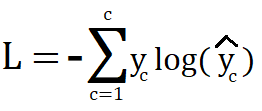

In [126]:
class Logistic_regression_grad():
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def _ce_loss(self,y_true, y_hat):
        
        # first part of the function is to perform one hot encode among 10 classes
        # it is an alternative to function _one_hot(below), but output os the same
        # in other words we can say that we constract ground true vectors
        # Examples: 
        # input value = 0 , so encoded output among 10 classes -> [1,0,0,0,0,0,0,0,0,0]
        # or input value = 7, so encoded output among 10 classes -> [0,0,0,0,0,0,0,7,0,0]
        #
        # this encoding is necessary to compute correctly loss 
        # in loss function we multiply log form of predcited probability of a class by encoded versio nof true class
        # Example:
        # encoded true vector = [1,0,0,0,0,0,0,0,0,0], 
        # while predictions [0.0059, 0.0110, 0.00267, 0.1562, 0.00068, 0.4192, 0.02406, 0.3666, 0.0111, 0.00236] 
        # so output of multiplication will be -5.11922341 because of logarifm
        # without logarifm = 0.0059
        # summing up across of obresvations will give us final loss results 
        
        y_encoded = []
        res = 0
        for i in range(len(y_true)):
            s = np.zeros(self.num_of_class)
            s[y_true[i]] =1 
            y_encoded.append(s)
        
        for i in range(len(y_true)):
            opa = -1.* sum(y_encoded[i]*np.log(y_hat[i]))
            res+=opa
        return res/len(y_true)
    
    def _softmax(self,z):

        # subtracting the max of z for numerical stability.
        exp = np.exp(z - np.max(z))
        
        # Calculating softmax for all examples.
        for i in range(len(z)):
            exp[i] /= np.sum(exp[i])
            
        return exp
    
    def _one_hot(self,y):

        # zero matrix of size (m, num_of_class)
        # it is just a template to perform one hot encode
        y_hot = np.zeros((len(y), self.num_of_class))

        y_hot[np.arange(len(y)), y] = 1

        return y_hot
    
    def train(self, x, y, epochs, batch_size, lr, num_of_class):
    
        row, col = x.shape
        self.batch_size = batch_size
        self.lr = lr # lerning rate
        self.num_of_class = num_of_class
        # initialize weights
        self.w = np.random.rand(col, self.num_of_class)/ np.sqrt(col)
        self.w0 = 1
        # list to store computed losses
        self.losses = []
        # defining bath size
        num_batches = x.shape[0]//self.batch_size
        
        for epoch in range(epochs):
            print("epoch: ", epoch)
            for batch_num in range(num_batches+1):
                
                # slicing data by batch 
                start = batch_num * self.batch_size
                end = (batch_num + 1) * self.batch_size
                
                x_batched = x[start:end]
                y_batched = y[start:end]

                y_hat = self._softmax(np.dot(x_batched, self.w) + self.w0)
    
                # IMPORTANT: 
                # to one hot function pass y_batched as 1-d array flat , NOT A COLUMN!!
                y_hot = self._one_hot(y_batched)

                error = y_hat - y_hot
         
                loss = self._ce_loss(y_batched, y_hat)
                self.losses.append(loss)
                
                gradient_w = (1/self.batch_size)*np.dot(x_batched.T, error)
                gradient_w0 = (1/self.batch_size)*np.sum(error) 
                
                # adjusting weights/theta with learning rate annd calculated gradient 
                self.w -= self.lr*gradient_w
                self.w0 -= self.lr*gradient_w0
                     
        return self.losses, self.w, self.w0        
    
    def predict(self, x_test):
        
        # predict on text data with calculated weigths/theta
        y_hat = self._softmax(np.dot(x_test, self.w) + self.w0)

        predictions_array = np.argmax(y_hat, axis=1)

        return predictions_array

In [12]:
# changing shapes from 3d to 2d 
X_train  = X_train.reshape(3823,64)

In [14]:
X_train.shape

(3823, 64)

In [73]:
X_test.shape

(1797, 8, 8)

In [74]:
X_test = X_test.reshape(1797,64)

In [61]:
# supressing engineering display of numerical data in numpy
np.set_printoptions(suppress=True) 

In [127]:
model = Logistic_regression_grad()

In [128]:
losses,w, w0=  model.train(X_train,y_train, 5, 200, 0.01, 10)

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4


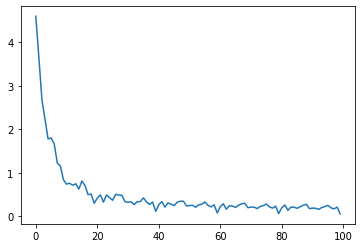

In [129]:
plt.plot(losses)

In [130]:
p_array = model.predict(X_test)

In [131]:
correct = sum(y_test ==p_array)
incorrect = len(y_test) - correct
print("Correct: {}".format(correct))
print("Incorrect: {}".format(incorrect))
print("Accuracy: {:2.2%}".format(correct/len(y_test)))

Correct: 1654
Incorrect: 143
Accuracy: 92.04%
